<a href="https://colab.research.google.com/github/thedavidemmanuel/chatbot-with-transformers/blob/main/gitbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GitHub Support Chatbot Using BERT
## BSE - ML Techniques I Assignment

Dataset Source: Custom GitHub support dataset (gitbotdataset.csv)

Architecture: BERT + Neural Network

Author: David Emmanuel

Date: October 2024
"""

# 1. Import Required Libraries

In [14]:
# Import Required Libraries
import numpy as np
import pandas as pd
import json
import pickle
import random
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Load and Explore Data

In [15]:
# Load and Explore Data
print("Loading dataset...")
df = pd.read_csv("/content/gitbotdataset.csv")

print("\nDataset Overview:")
print(f"Total samples: {len(df)}")
print("\nSample distribution by intent:")
print(df['Intent'].value_counts())

Loading dataset...

Dataset Overview:
Total samples: 341

Sample distribution by intent:
Intent
git_pull              27
greetings             24
clone_repo            23
repo_delete           23
commit_changes        22
thanks                20
goodbye               20
repo_status           19
create_repo           19
git_push              16
actions_workflows     16
issue_creation        13
pull_request          13
repo_collaboration    13
merge_conflict        13
branch_management     12
repo_visibility       12
issue_labels          11
fork_repo             10
settings_changes      10
milestones             2
git_ignore             2
notifications          1
Name: count, dtype: int64


# 3. Data Preprocessing

In [16]:
# Data Preprocessing
print("\nPreprocessing data...")

# Initialize BERT models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
lemmatizer = WordNetLemmatizer()

# Create intents dictionary
dict_ = {"intents": []}
for _, row in df.iterrows():
    dict1 = {
        'tags': [row['Intent']],
        'patterns': [row['Example User Input'].strip('"')],
        'responses': [row['Bot Response'].strip('"')]
    }
    dict_['intents'].append(dict1)

# Save intents
with open("github_intents.json", "w") as f:
    json.dump(dict_, f)

# Initialize processing lists
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']


Preprocessing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# 4. Feature Extraction using BERT

In [17]:
# Feature Extraction using BERT

def get_bert_embedding(sentence):
    """Extract BERT embeddings for a given sentence"""
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Process intents
for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

# Lemmatize and sort words
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

# Save preprocessed data
pickle.dump(words, open('github_words.pkl', 'wb'))
pickle.dump(classes, open('github_classes.pkl', 'wb'))

# 5. Prepare Training Data

In [18]:
# Prepare Training Data

print("\nPreparing training data...")
training = []
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

# Split data into features and labels
X = np.array([item[0] for item in training])
y = np.array([item[1] for item in training])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



Preparing training data...


# 6. Model Architecture

In [19]:
# Model Architecture

print("\nBuilding model...")
model = Sequential()
model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y_train[0]), activation='softmax'))

# Learning rate schedule for better convergence
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile model with multiple metrics
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

print("\nModel Summary:")
model.summary()



Building model...

Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 23)                  │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,183 (422.59 KB)

 Trainable params: 108,183 (422.59 KB)

 Non-trainable params: 0 (0.00 B)

# 7. Model Training

In [20]:
# Model Training

print("\nTraining model...")
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=12,
                   validation_data=(X_val, y_val),
                   verbose=1)


Training model...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0548 - loss: 3.1732 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 2.8392
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Precision: 0.1667 - Recall: 6.2954e-04 - accuracy: 0.3171 - loss: 2.7246 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4058 - val_loss: 2.4335
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.7500 - Recall: 0.0267 - accuracy: 0.3743 - loss: 2.3748 - val_Precision: 0.9091 - val_Recall: 0.1449 - val_accuracy: 0.5072 - val_loss: 1.9967
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.8907 - Recall: 0.1705 - accuracy: 0.4671 - loss: 1.9410 - val_Precision: 0.8333 - val_Recall: 0.2174 - val_accuracy: 0.5362 - val_loss: 1.7250
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.9500 - Recall: 0.3187 - accuracy: 0.5981 - loss: 1.491

# 8. Model Evaluation


Evaluating model...


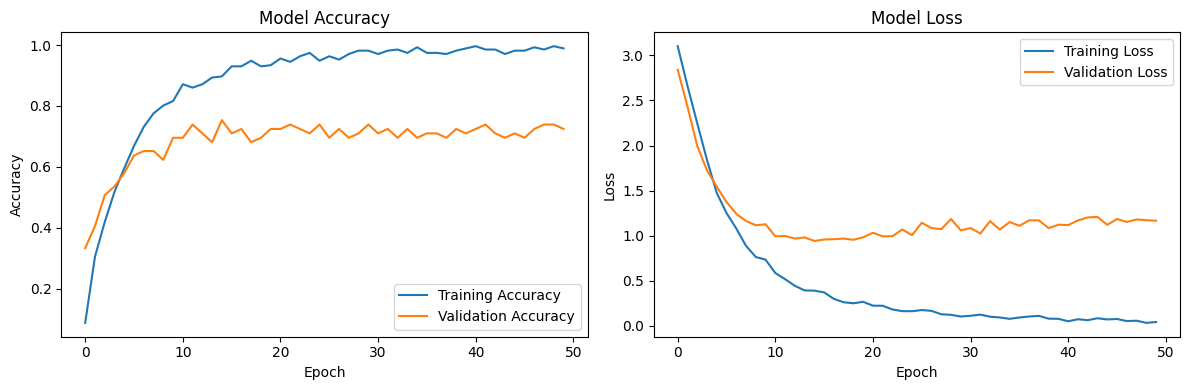

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step

Validation Metrics:
Accuracy: 0.7246
F1 Score: 0.7248


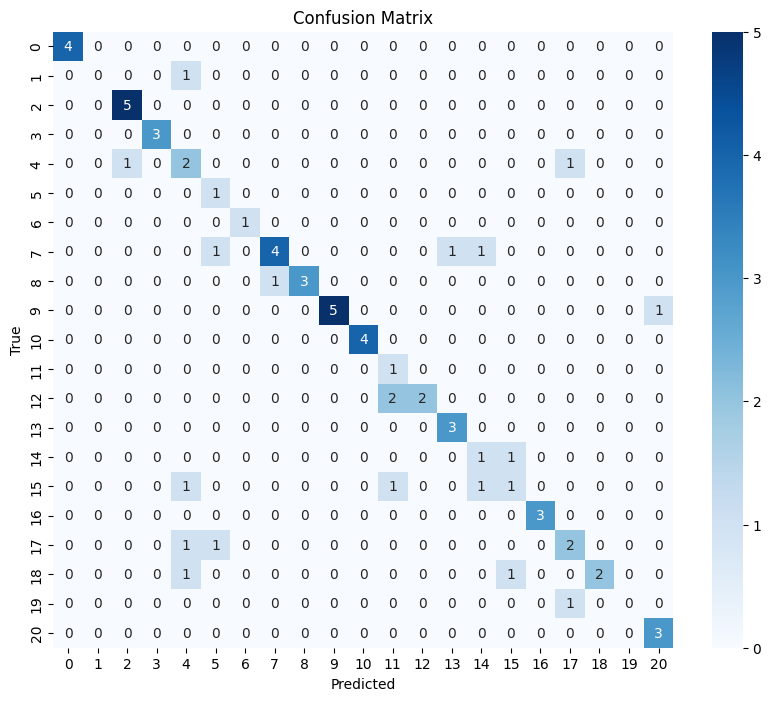

In [21]:
# Model Evaluation

print("\nEvaluating model...")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate validation metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val_classes, y_pred_classes):.4f}")
print(f"F1 Score: {f1_score(y_val_classes, y_pred_classes, average='weighted'):.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 9. Save Model

In [22]:
# Save Model

model.save('github_chatbot_model.h5')
print("\nModel saved successfully!")


Model saved successfully!


# 10. Chatbot Interface

In [24]:
# Chatbot Interface

def predict_class(sentence):
    """Predict the intent class of a given sentence"""
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    """Get appropriate response based on predicted intent"""
    if not intents_list:
        return "I'm not sure how to help with that. Could you rephrase your question?"
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "I don't understand. Could you try asking in a different way?"

11. Interactive Testing


In [25]:
# Interactive Testing

print("\nGitHub ChatBot is Active (type 'quit' to exit)")
print("Example queries:")
print("- How do I create a repository?")
print("- What is a pull request?")
print("- How do I fork a repository?")

while True:
    message = input("\nYou: ")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye!")
        break

    ints = predict_class(message)
    response = get_response(ints, dict_)
    print(f"Bot: {response}")

    # Log confidence scores for analysis
    if ints:
        print(f"Confidence: {float(ints[0]['probability']):.2%}")


GitHub ChatBot is Active (type 'quit' to exit)
Example queries:
- How do I create a repository?
- What is a pull request?
- How do I fork a repository?

You: What is a pull request?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Bot: Go to the repository settings, click Collaborators, and invite users.
Confidence: 50.44%

You: Git commit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Bot: Use git commit -m 'your message' to save your changes.
Confidence: 86.19%

You: How to create repository
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Bot: Go to GitHub, click 'New', and follow the steps.
Confidence: 93.68%

You: Thanks!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Bot: You're welcome!
Confidence: 100.00%

You: Bye!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Bot: Goodbye! Take care!
Confidence: 100.00%

You: quit
Goodbye!
